In [38]:
from pprint import pprint
import seaborn as sns
import numpy as np
from sqlalchemy import PickleType, create_engine
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import pickle
import logging
import yaml
import pandas as pd

from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types

sns.set_theme()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [25]:
dtypes = get_sql_types()
dtypes["value_history"] = PickleType

In [26]:
engine = create_engine("sqlite:///pretty_plots.db")
print(engine.table_names())
del engine

['camel', 'camel2', 'camel_hp_winners', 'camel_hpsearch']


In [27]:
df = read_pkl_sql("pretty_plots.db", "camel_hp_winners", dtypes=dtypes)
df.columns = df.columns.astype(str)
clean_df = df.dropna(subset=["variance_ratio", "s"]).sort_values("variance_ratio", ascending=False)
clean_df["d_cat"] = clean_df["d"].astype(str)
matched = clean_df[clean_df["match"]]

dfall = read_pkl_sql("pretty_plots.db", "camel_hpsearch", dtypes=dtypes)
dfall.columns = dfall.columns.astype(str)
clean_df = dfall.dropna(subset=["variance_ratio", "s"]).sort_values("variance_ratio", ascending=False)
clean_df["d_cat"] = clean_df["d"].astype(str)
matched_all = clean_df[clean_df["match"]]

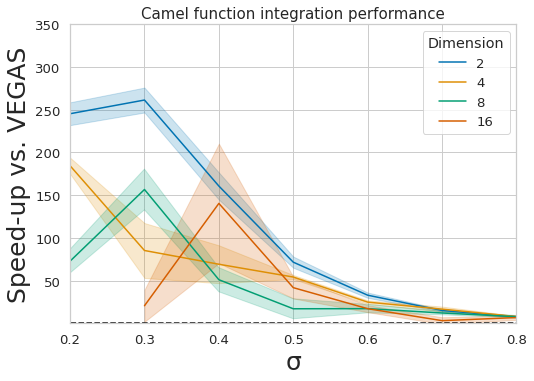

In [41]:
ax = sns.lineplot(data=matched, x="s", y="variance_ratio", hue="d_cat", ci="sd", palette="colorblind", hue_order=[str(d) for d in sorted(matched["d"].unique())])
ax.legend(title="Dimension",  loc="upper right")
ax.set(yscale="linear",xlim=[0.2, 0.8], ylim=[1.e-1, 3.5e2])
ax.set_xlabel("σ", size=25)
ax.set_ylabel("Speed-up vs. VEGAS", size=25)
ax.set_title("Camel function integration performance", fontsize=15)
ax.plot([0,1],[1,1], c="black", linestyle="dashed")
ax.get_figure().set_size_inches(8,5.5)
plt.show()

# ax = sns.lineplot(data=matched, x="s", y="variance_ratio", hue="d_cat", ci="sd", palette="colorblind", hue_order=[str(d) for d in sorted(matched["d"].unique())])
# ax.legend(title="Dimension",  loc="upper right")
# ax.set(yscale="log",xlim=[0.2, 0.8], ylim=[1.e-1, 3.5e2])
# ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function integration performance")
# ax.plot([0,1],[1,1], c="black", linestyle="dashed")
# ax.get_figure().set_size_inches(8,5.5)
# plt.show()

# ax = sns.lineplot(data=matched_all, x="s", y="variance_ratio", hue="d_cat", ci="sd", palette="colorblind", hue_order=[str(d) for d in sorted(matched["d"].unique())])
# ax.legend(title="Dimension",  loc="upper right")
# ax.set(yscale="log",xlim=[0.1, 0.8], ylim=[1.e-1, 1.e3])
# ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
# ax.plot([0,1],[1,1], c="black", linestyle="dashed")
# ax.get_figure().set_size_inches(8,5.5)
# plt.show()

In [70]:
matched = matched.assign(data="best")
matched_all = matched_all.assign(data="all")

matched_validate = pd.concat([matched,matched_all], ignore_index=True)

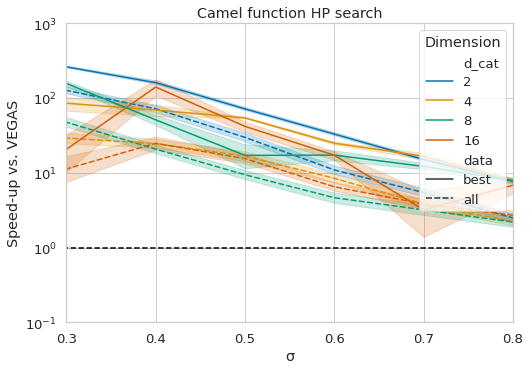

In [71]:
ax = sns.lineplot(data=matched_validate, x="s", y="variance_ratio", hue="d_cat", palette="colorblind", hue_order=[str(d) for d in sorted(matched["d"].unique())], style="data")
ax.legend(title="Dimension",  loc="upper right")
ax.set(yscale="log",xlim=[0.3, 0.8], ylim=[1.e-1, 1.e3])
ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
ax.plot([0,1],[1,1], c="black", linestyle="dashed")
ax.get_figure().set_size_inches(8,5.5)
plt.show()

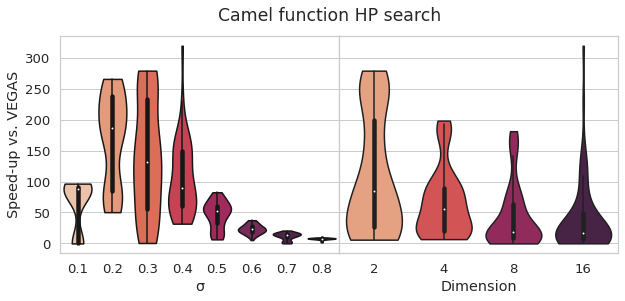

In [72]:
vmatched = matched[(matched["variance_ratio"] < 500)]
fig, axs = plt.subplots(1,2, sharey=True, gridspec_kw={"wspace":0})
fig.suptitle("Camel function HP search")
sns.violinplot(data=vmatched, x="s", y="variance_ratio", cut=0, scale="width", ax=axs[0], palette="rocket_r")
axs[0].set(xlabel="σ", ylabel="Speed-up vs. VEGAS")
sns.violinplot(data=vmatched, x="d", y="variance_ratio", cut=0, scale="width", ax=axs[1], palette="rocket_r")
axs[1].set(xlabel="Dimension", ylabel="")
fig.set_size_inches(10,4)
plt.show()

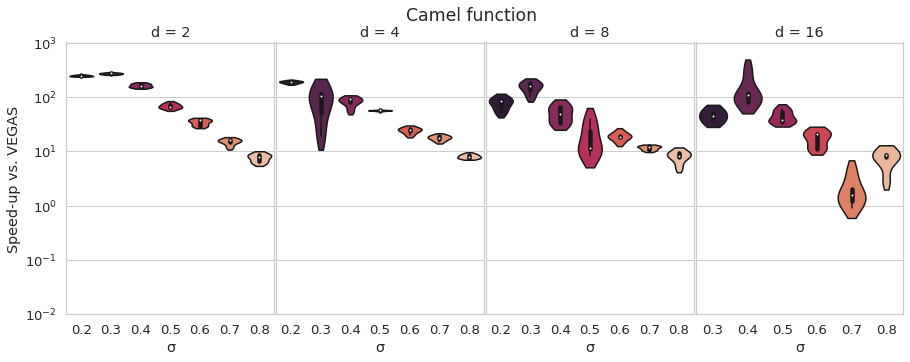

In [53]:
vmatched = matched[(matched["variance_ratio"] < 1000) & (matched["s"]>0.1)]
vmatched = vmatched.assign(lvr=vmatched.loc[:,"variance_ratio"].apply(np.log10).values)
dims = list(vbetter["d"].unique())
dims.sort()
fig, axs = plt.subplots(1,4, sharey="row", gridspec_kw={"wspace":.01, "hspace":.3})
fig.suptitle("Camel function")
for i in range(len(axs)):
    sns.violinplot(data=vmatched[vmatched["d"]==dims[i]], x="s", y="lvr", cut=1, scale="width", ax=axs[i], palette="rocket")
    axs[i].set(xlabel="σ", title=f"d = {dims[i]}", ylabel="")
axs[0].set(ylabel="Speed-up vs. VEGAS", ylim=(-2,3))
axs[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
fig.set_size_inches(15,5)
plt.show()

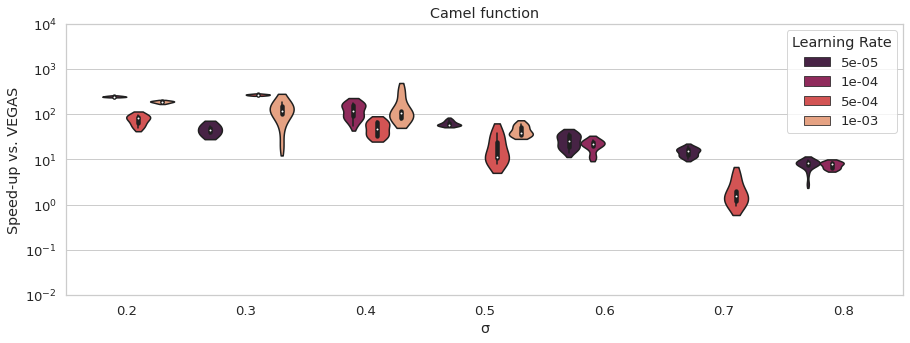

In [54]:
ax = sns.violinplot(data=vmatched, x="s", y="lvr", hue="lr", scale="width", cut=1, palette="rocket")
ax.set(ylim=(-2,4))
ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
legend = ax.legend(loc="upper right", title="Learning Rate", frameon=True)
for lbl in legend.get_texts():
    lr = float(lbl.get_text())
    lbl.set_text(f"{lr:.0e}")
ax.get_figure().set_size_inches(15,5)

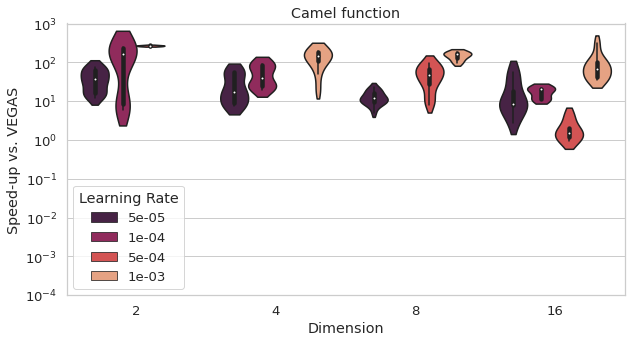

In [55]:
ax = sns.violinplot(data=vmatched, x="d", y="lvr", hue="lr", scale="width", cut=1, palette="rocket")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.get_figure().set_size_inches(10,5)
ax.set(ylim=(-4,3))
ax.set(xlabel="Dimension", ylabel="Speed-up vs. VEGAS", title="Camel function")
legend = ax.legend(loc="lower left", title="Learning Rate", frameon=True)
for lbl in legend.get_texts():
    lr = float(lbl.get_text())
    lbl.set_text(f"{lr:.0e}")
plt.show()

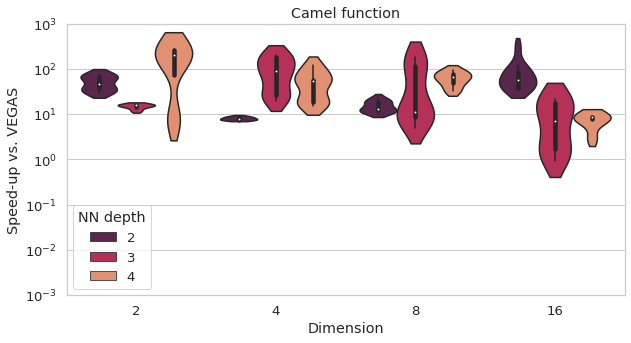

In [56]:
ax = sns.violinplot(data=vmatched, x="d", y="lvr", hue="n_hidden", scale="width", cut=1, palette="rocket")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.get_figure().set_size_inches(10,5)
ax.set(ylim=(-3,3))
ax.set(xlabel="Dimension", ylabel="Speed-up vs. VEGAS", title="Camel function")
legend = ax.legend(loc="lower left", title="NN depth", frameon=True)
plt.show()

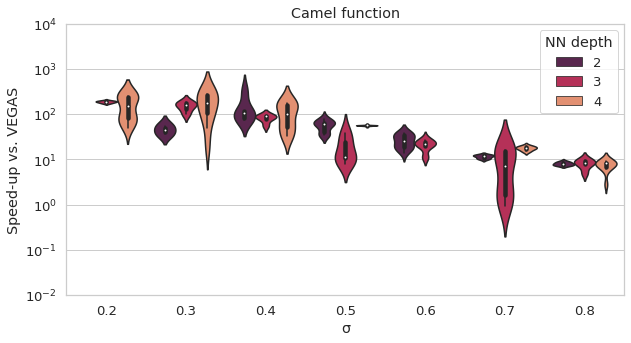

In [57]:
ax = sns.violinplot(data=vmatched, x="s", y="lvr", hue="n_hidden", scale="width", palette="rocket")
ax.set(ylim=(-2,4))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function")
ax.legend(loc="upper right", title="NN depth")
ax.get_figure().set_size_inches(10,5)

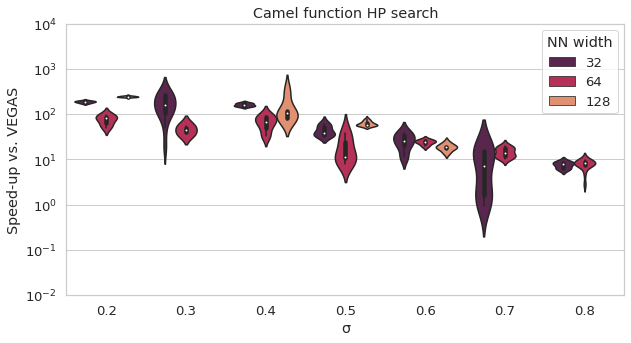

In [62]:
ax = sns.violinplot(data=vmatched, x="s", y="lvr", hue="d_hidden", scale="width", palette="rocket")
ax.set(ylim=(-2,4))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
ax.legend(loc="upper right", title="NN width")
ax.get_figure().set_size_inches(10,5)
plt.show()

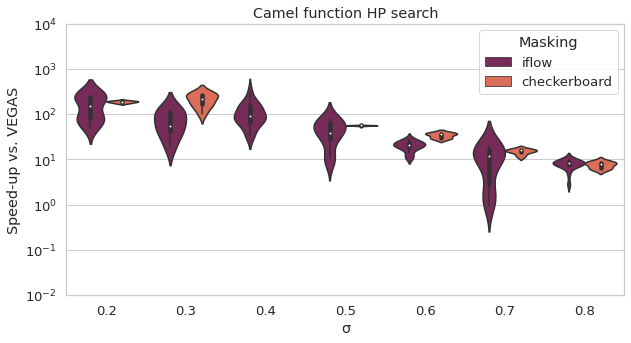

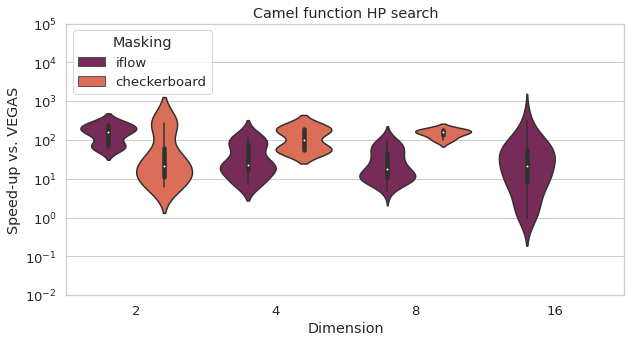

In [63]:
ax = sns.violinplot(data=vmatched, x="s", y="lvr", hue="masking", scale="width", palette="rocket")
ax.set(ylim=(-2,4))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
ax.legend(loc="upper right", title="Masking")
ax.get_figure().set_size_inches(10,5)
plt.show()

ax = sns.violinplot(data=vmatched, x="d", y="lvr", hue="masking", scale="width", palette="rocket")
ax.set(ylim=(-2,5))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.set(xlabel="Dimension", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
ax.legend(loc="upper left", title="Masking")
ax.get_figure().set_size_inches(10,5)
plt.show()

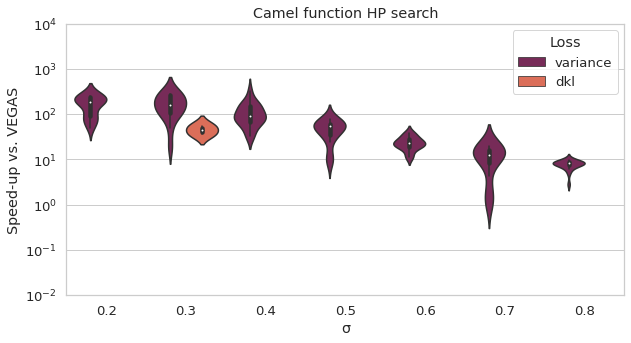

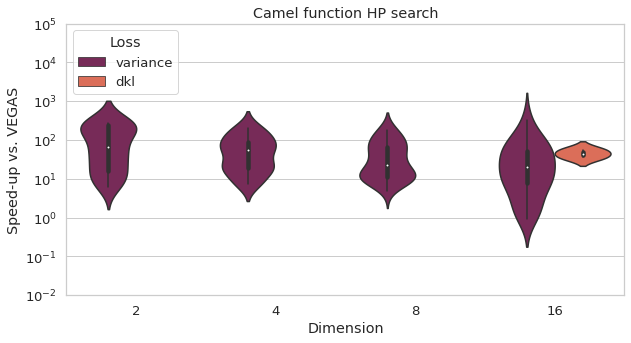

In [64]:
ax = sns.violinplot(data=vmatched, x="s", y="lvr", hue="loss", scale="width", palette="rocket")
ax.set(ylim=(-2,4))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.set(xlabel="σ", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
ax.legend(loc="upper right", title="Loss")
ax.get_figure().set_size_inches(10,5)
plt.show()

ax = sns.violinplot(data=vmatched, x="d", y="lvr", hue="loss", scale="width", palette="rocket")
ax.set(ylim=(-2,5))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.set(xlabel="Dimension", ylabel="Speed-up vs. VEGAS", title="Camel function HP search")
ax.legend(loc="upper left", title="Loss")
ax.get_figure().set_size_inches(10,5)
plt.show()